In [1]:
import numpy as np
from itertools import cycle
import os
import dask.array as da
import dask.bag as db
import numpy as np
import xarray as xr
import xesmf as xe
import subprocess
from scipy.ndimage import binary_fill_holes
from importlib import reload
os.chdir("/home/149/ab8992/cosima_regional/mom6-regional-scripts")
import regional_library as ml

# Test run! See if we get a working model from the experiment class

In [ ]:
reload(ml)

## Choose your coordinates and the name of your experiment
yextent = [-48,-38.95]
xextent = [-217 + 360, -210 + 360]
expt_name = "test-pathway"

pwd = "$KQ%QqFxjSSbE2"
usr = "abarnes"


daterange = ["2015-01-01 00:00:00", "2015-01-31 00:00:00"]

## Place where all your input files go
inputdir = f"/scratch/v45/ab8992/mom6/regional_configs/{expt_name}/"

## Directory where you'll run the experiment from
rundir = f"/home/149/ab8992/mom6_rundirs/{expt_name}/"

## Directory where raw downloads go before processing
tmpdir = f"/scratch/v45/ab8992/reanalysis_tmp/reanalysis-small/"

## Directory where fre tools are stored
toolpath = "/home/157/ahg157/repos/mom5/src/tools/" ## Compiled tools needed for construction of mask tables


expt = ml.experiment(
    xextent,
    yextent,
    0.0333,
    75,
    2,
    3000,
    rundir,
    inputdir,
    toolpath
)

a = expt.ocean_forcing(
    tmpdir,
    {"time":"time","y":"latitude","x":"longitude","zl":"depth","eta":"zos","u":"uo","v":"vo","tracers":{"salt":"so","temp":"thetao"}},
    boundaries = ["south","north","west","east"]
    )

expt.bathymetry(
    '/g/data/ik11/inputs/GEBCO_2022/GEBCO_2022.nc',
    {"xh":"lon","yh":"lat","elevation":"elevation"},
    )


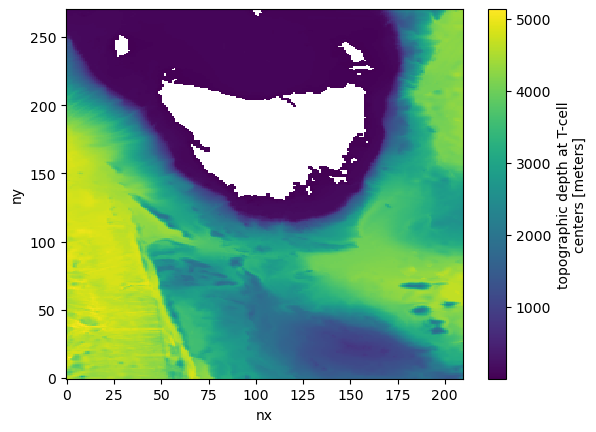

In [56]:
topog = xr.open_dataset("/scratch/v45/ab8992/mom6/regional_configs/test-pathway/new_topog.nc", engine='netcdf4')
topog.depth.plot()

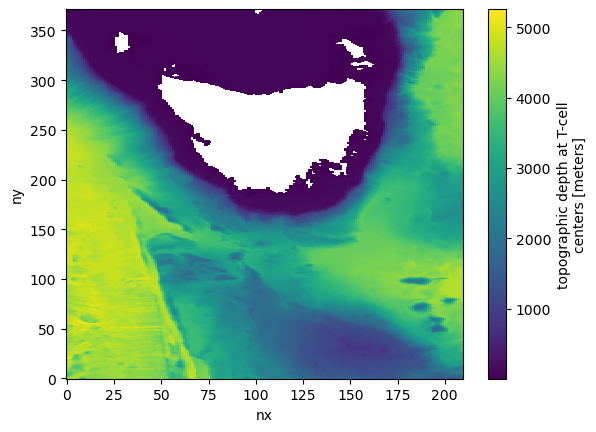

In [46]:
topog = xr.open_dataset("/scratch/v45/ab8992/mom6/regional_configs/tassie_30th/topog.nc", engine='netcdf4')
topog.depth.plot()

## Things to handle:
* Forcing files that have negative longitudes. Should ensure that xextent always means the same thing
* Have all of my compiled fre tools together in the same folder

## Below is stuff copied from the old notebook that's not in pipeline. 
* Runoff
* Make mask
* copy default run directory

In [6]:
inputdir

'/scratch/v45/ab8992/mom6/regional_configs/test-pathway/'

In [54]:

args = "--num_tiles 1 --dir . --mosaic_name ocean_mosaic --tile_file hgrid.nc".split(" ")

print("MAKE SOLO MOSAIC",subprocess.run([toolpath + "make_solo_mosaic/make_solo_mosaic"] + args,cwd = inputdir),sep = "\n")


NOTE from make_solo_mosaic: there are 0 contacts (align-contact)
congradulation: You have successfully run make_solo_mosaic
MAKE SOLO MOSAIC
CompletedProcess(args=['/home/157/ahg157/repos/mom5/src/tools/make_solo_mosaic/make_solo_mosaic', '--num_tiles', '1', '--dir', '.', '--mosaic_name', 'ocean_mosaic', '--tile_file', 'hgrid.nc'], returncode=0)


cp: './ocean_mosaic.nc' and 'ocean_mosaic.nc' are the same file
cp: './hgrid.nc' and 'hgrid.nc' are the same file


cp ./hgrid.nc hgrid.nc 

NOTE from make_coupler_mosaic: the ocean land/sea mask will be determined by field depth from file topog.nc
mosaic_file is grid_spec.nc

***** Congratulation! You have successfully run make_quick_mosaic
QUICK MOSAIC
CompletedProcess(args=['/home/157/ahg157/repos/mom5/src/tools/make_quick_mosaic/make_quick_mosaic', '--input_mosaic', 'ocean_mosaic.nc', '--mosaic_name', 'grid_spec', '--ocean_topog', 'topog.nc'], returncode=0)

 ===>NOTE from check_mask: when layout is specified, min_pe and max_pe is set to layout(1)*layout(2)=100

 ===>NOTE from check_mask: Below is the list of command line arguments.

grid_file = ocean_mosaic.nc
topog_file = topog.nc
min_pe = 100
max_pe = 100
layout = 10, 10
halo = 4
sea_level = 0
show_valid_only is not set
nobc = 0

 ===>NOTE from check_mask: End of command line arguments.

 ===>NOTE from check_mask: the grid file is version 2 (mosaic grid) grid which contains field gridfiles

==>NOTE from get_boundary_type: x_boundary_type is s

In [4]:
args = "--input_mosaic ocean_mosaic.nc --mosaic_name grid_spec --ocean_topog topog.nc".split(" ")

print("QUICK MOSAIC" , subprocess.run(
    toolpath + "make_quick_mosaic/make_quick_mosaic --input_mosaic ocean_mosaic.nc --mosaic_name grid_spec --ocean_topog topog.nc",
    shell=True
    ,cwd = inputdir),sep = "\n")

cp ./hgrid.nc hgrid.nc 

NOTE from make_coupler_mosaic: the ocean land/sea mask will be determined by field depth from file topog.nc
mosaic_file is grid_spec.nc

***** Congratulation! You have successfully run make_quick_mosaic
QUICK MOSAIC
CompletedProcess(args='/home/157/ahg157/repos/mom5/src/tools/make_quick_mosaic/make_quick_mosaic --input_mosaic ocean_mosaic.nc --mosaic_name grid_spec --ocean_topog topog.nc', returncode=0)


cp: './ocean_mosaic.nc' and 'ocean_mosaic.nc' are the same file
cp: './hgrid.nc' and 'hgrid.nc' are the same file


In [5]:
## I've set the layout to default to 10x10 cpus
args = "".split(" ")

print("CHECK MASK" , subprocess.run(toolpath + "check_mask/check_mask --grid_file ocean_mosaic.nc --ocean_topog topog.nc --layout 10,10 --halo 4",shell=True,cwd = inputdir))


 ===>NOTE from check_mask: when layout is specified, min_pe and max_pe is set to layout(1)*layout(2)=100

 ===>NOTE from check_mask: Below is the list of command line arguments.

grid_file = ocean_mosaic.nc
topog_file = topog.nc
min_pe = 100
max_pe = 100
layout = 10, 10
halo = 4
sea_level = 0
show_valid_only is not set
nobc = 0

 ===>NOTE from check_mask: End of command line arguments.

 ===>NOTE from check_mask: the grid file is version 2 (mosaic grid) grid which contains field gridfiles

==>NOTE from get_boundary_type: x_boundary_type is solid_walls

==>NOTE from get_boundary_type: y_boundary_type is solid_walls

==>NOTE from check_mask: Checking for possible masking:
==>NOTE from check_mask: Assume 4 halo rows
==>NOTE from check_mask: Total domain size is 210, 271

_______________________________________________________________________

NOTE from check_mask: The following is for using model source code with version older than siena_201207,
Possible setting to mask out all-land poin

In [61]:
from regional_model_scripts import regrid_runoff
runoff_path = "/g/data/ik11/inputs/JRA-55/RYF/v1-3/RYF.runoff_all.1990_1991.nc"

regrid_runoff(inputdir + "ocean_mask.nc",
    inputdir + "hgrid.nc",
    runoff_path,
    inputdir + "runoff_regrid.nc",
    np.array(xextent) - np.array([180,180]),
    yextent)

In [60]:
xextent

[143, 150]

In [63]:
subprocess.run(f"cp default_rundir/* {rundir}",shell = True)
subprocess.run(f"ln -s {inputdir} {rundir}/inputdir",shell=True)

hgrid = xr.open_dataset(f"{inputdir}/hgrid.nc")

## Get mask table information
ncpus = 100
mask_table = None
for i in os.listdir(f"{inputdir}"):
    if "mask_table" in i:
        mask_table = i
        a = mask_table.split(".")[1]
        b = mask_table.split(".")[2].split("x")
        ncpus = int(b[0]) * int(b[1]) - int(a)


## Modify MOM_input
inputfile = open(f"{rundir}/MOM_input",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "MASKTABLE" in lines[i]:
        if mask_table != None:
            lines[i] = f'MASKTABLE = "{mask_table}"\n'
        else:
            lines[i] = "# MASKTABLE = no mask table"
    if "NIGLOBAL" in lines[i]: 
        # lines[i] = f"NIGLOBAL = {str(x_indices_centre[1] - x_indices_centre[0])}\n"
        lines[i] = f"NIGLOBAL = {hgrid.nx.shape[0]//2}\n"

        
    if "NJGLOBAL" in lines[i]:
        # lines[i] = f"NJGLOBAL = {str(y_indices_centre[1] - y_indices_centre[0])}\n"
        lines[i] = f"NJGLOBAL = {hgrid.ny.shape[0]//2}\n"

        
inputfile = open(f"{rundir}/MOM_input",'w')

inputfile.writelines(lines)
inputfile.close()

## Modify SIS_input
inputfile = open(f"{rundir}/SIS_input",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "MASKTABLE" in lines[i]:
        lines[i] = f'MASKTABLE = "{mask_table}"\n'
    if "NIGLOBAL" in lines[i]:
        # lines[i] = f"NIGLOBAL = {str(x_indices_centre[1] - x_indices_centre[0])}\n"
        lines[i] = f"NIGLOBAL = {hgrid.nx.shape[0]//2}\n"
        
    if "NJGLOBAL" in lines[i]:
        # lines[i] = f"NJGLOBAL = {str(y_indices_centre[1] - y_indices_centre[0])}\n"
        lines[i] = f"NJGLOBAL = {hgrid.ny.shape[0]//2}\n"
        
inputfile = open(f"{rundir}/SIS_input",'w')
inputfile.writelines(lines)
inputfile.close()

## Modify config.yaml 
inputfile = open(f"{rundir}/config.yaml",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "ncpus" in lines[i]:
        lines[i] = f'ncpus: {str(ncpus)}\n'
    if "jobname" in lines[i]:
        lines[i] = f"jobname: mom6_{expt_name}\n"
        
    if "input:" in lines[i]:
        lines[i + 1] = f"    - {inputdir}\n"
        
inputfile = open(f"{rundir}/config.yaml",'w')
inputfile.writelines(lines)
inputfile.close()

subprocess.run(f"cp vcoord.nc {inputdir}",shell=True)

ln: failed to create symbolic link '/home/149/ab8992/mom6_rundirs/test-pathway//inputdir/test-pathway': File exists


CompletedProcess(args='cp vcoord.nc /scratch/v45/ab8992/mom6/regional_configs/test-pathway/', returncode=0)